In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from matplotlib import cm
from matplotlib.lines import Line2D

plt.style.use('ggplot')
plt.rcParams["savefig.format"] = 'svg'
plt.rcParams['image.cmap'] = 'viridis'

np.random.seed(42)

class_colors = cm.tab10

# Real concept drift

Considers any change on $P(Y|X)$ from training to test. We will refer to them as source $D_s$ (training) and target $D_t$ (test) sets.

$$P_s(Y|X) \neq P_t(Y|X)$$

We also consider that the data distribuion is different

$$P_s(X) \neq P_t(X)$$

We may also consider that the labels in the source domain are not exhaustive $\mathcal{Y_s} \subseteq \mathcal{Y_t}$ but that the target domain in order to evaluate the methos is.

In this Notebook we present a toy example in which 2 classes are present during training, while in the unlabelled and test set there are 3 classes. Any prediction of the original model on the 3rd class will be wrong, as the model is not aware about that class during training. The objective here is to be able to obtain a confidence level per instance that indicates how confident is the model about the predicted class. In a more common scenario in which no new classes appear and the posterior probabilities given the input remain the same, it is common to consider the highest probability output by the model as the confidence. However, in our setting this is not the case, as the data from both source and target domains are not i.i.d.

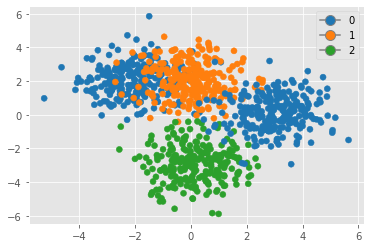

In [2]:
#n_samples=1000
#n_features=2
#x, y = make_blobs(n_samples=n_samples, n_features=n_features,
#                  centers=[[0, 1],[2, 3]], shuffle=False)

n_samples=1000
n_features=2
centers= [[-2, 2], [0, 2], [0, -3], [3, 0]]
x, blob_id = make_blobs(n_samples=n_samples, n_features=n_features,
                        centers=centers, shuffle=False)
y = blob_id%3

plt.scatter(x[:, 0], x[:, 1], c=class_colors(y))
plt.legend([Line2D([0], [0], marker='o', color='grey', label='Scatter',
                   markerfacecolor=class_colors(i), markersize=10) for i in np.unique(y)],
           np.unique(y).astype(str))

dataset_name = 'unknown_classes_blobs_s_{}_f_{}_c_manual'.format(n_samples, n_features)

plt.savefig('{}'.format(dataset_name))

## WARNING:

The labeled training set requires that the labels are consequtive from $0$ to $K$, where $K$ is the number of known classes.

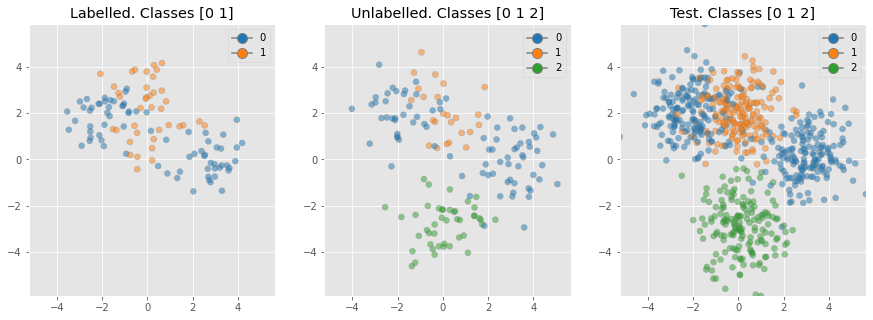

In [3]:
shuffle=False
dataset_name += '_iid' if shuffle else '_ood'
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7, shuffle=True)
x_label, x_unlabel, y_label, y_unlabel = train_test_split(x_train, y_train, test_size=0.5, shuffle=True)

if not shuffle:
    x_label = x_label[y_label < 2]
    y_label = y_label[y_label < 2]

x_min, y_min = x.min(axis=0)
x_max, y_max = x.max(axis=0)

n_known_classes = len(np.unique(y_label))
n_unlabelled_classes = len(np.unique(y_unlabel))
n_test_classes = len(np.unique(y_test))
n_all_classes = len(np.unique(y))

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Labelled. Classes {}'.format(np.unique(y_label)))
ax.scatter(x_label[:,0], x_label[:,1], c=class_colors(y_label), edgecolor='grey',
           alpha=0.5, cmap='tab10')
ax.legend([Line2D([0], [0], marker='o', color='grey', label='Scatter',
                   markerfacecolor=class_colors(i), markersize=10) for i in np.unique(y_label)],
           np.unique(y_label).astype(str))
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Unlabelled. Classes {}'.format(np.unique(y_unlabel)))
ax.scatter(x_unlabel[:,0], x_unlabel[:,1], c=class_colors(y_unlabel), edgecolor='grey', alpha=0.5, cmap='tab10')
ax.legend([Line2D([0], [0], marker='o', color='grey', label='Scatter',
                   markerfacecolor=class_colors(i), markersize=10) for i in np.unique(y_unlabel)],
           np.unique(y_unlabel).astype(str))
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Test. Classes {}'.format(np.unique(y_test)))
ax.scatter(x_test[:,0], x_test[:,1], c=class_colors(y_test), edgecolor='grey', alpha=0.5, cmap='tab10')
ax.legend([Line2D([0], [0], marker='o', color='grey', label='Scatter',
                   markerfacecolor=class_colors(i), markersize=10) for i in np.unique(y_test)],
           np.unique(y_test).astype(str))
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)
#plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black', alpha=0.5)
plt.savefig('{}_data_partitions'.format(dataset_name))

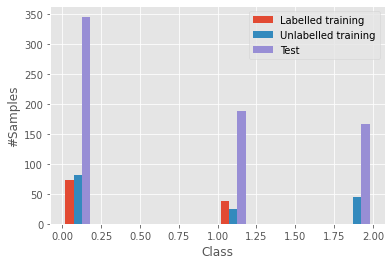

In [4]:
plt.hist([y_label, y_unlabel, y_test], label=['Labelled training', 'Unlabelled training', 'Test'])
plt.xlabel('Class')
plt.ylabel('#Samples')
plt.legend()

In [5]:
# generation of a grid for later model exploration
# define bounds of the domain
min1, max1 = x[:, 0].min()-1, x[:, 0].max()+1
min2, max2 = x[:, 1].min()-1, x[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_contourmap(clf, x, y, ax=None, cmap='viridis',
                    class_colors=class_colors):
    if ax is None:
        fig, ax = plt.subplots()
    # make predictions for the grid
    yhat = clf.predict_proba(grid)[:,1]
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    im = ax.contourf(xx, yy, zz, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax)
    #ax.colorbar(label='$p(y=1|x)$')
    ax.scatter(x[:,0], x[:,1], c=class_colors(y), edgecolors='grey',
                alpha=0.5, cmap=cmap)
    #plt.title('Accuarcy = {:0.3f}'.format(accuracy_score(y_l
    #plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black',
    #            alpha=0.5)abel, clf.predict(x_label))))
    return ax

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

#model = LogisticRegression()
#model = SVC(kernel='rbf', probability=True)

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

from tensorflow.nn import softmax_cross_entropy_with_logits

def brier_loss(y_true, y_pred):    
    """ Computes weighted brier score for the given tensors    
    
    equivalent to:    
            w = class_weigths    
            N, C = y_true.shape    
            bs = 0    
            for n in range(N):    
                for c in range(C):    
                    bs += (y_pred[n, c] - y_true[n, c])**2    
            return bs/N    
    """    
    return tf.math.reduce_mean(
        tf.math.reduce_sum(
            tf.math.square(
                tf.math.subtract(y_pred, tf.cast(y_true, 'float32'))), axis=1))  



# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(50,  # output dim is 2, one score per each class
                activation='tanh',
                kernel_regularizer=L1L2(l1=0.0, l2=0.01),
                input_dim=n_features))  # input dimension = number of features your data has
    model.add(Dense(50,  # output dim is 2, one score per each class
                activation='tanh',
                kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
    model.add(Dense(n_known_classes,  # output dim is 2, one score per each class
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
    model.compile(optimizer='sgd',
              loss=brier_loss, # 'categorical_crossentropy', # brier_loss, #
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=10, verbose=0)

#model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

In [9]:
# from https://stackoverflow.com/questions/31947140/sklearn-labelbinarizer-returns-vector-when-there-are-2-classes
from sklearn.preprocessing import LabelBinarizer
import numpy as np

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((1-Y, Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 1], threshold)
        else:
            return super().inverse_transform(Y, threshold)


# Obtaining confidence values

I propose to use as a confidence value of the classifier, the probability of a new instance comming from the labelled set $D_s$ (source) vs the unlabelled set $D_t$ (target).

$$P(D=s|X)$$

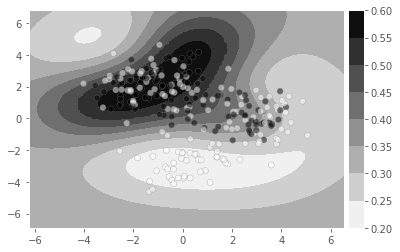

In [10]:
x_bgc = np.concatenate([x_label, x_unlabel])
y_bgc = np.concatenate([np.ones_like(y_label),
                        np.zeros_like(y_unlabel)])

from sklearn.utils import shuffle

x_bgc, y_bgc = shuffle(x_bgc, y_bgc)

from sklearn.svm import SVC
clf_bgc = SVC(kernel='rbf', probability=True)
#clf_bgc = clone(model)
#binarizer = MyLabelBinarizer()
#binarizer.fit(y_bgc)
#y_bgc_bin = binarizer.transform(y_bgc)
clf_bgc.fit(x_bgc, y_bgc)
    
plot_contourmap(clf_bgc, x_bgc, y_bgc, cmap='binary',
                class_colors=lambda x: (x)*4)
plt.savefig('{}_unl_vs_lab'.format(dataset_name))

In [11]:
from sklearn.preprocessing import label_binarize

def run_experiment(name='notweak', iterations=10):
    binarizer = MyLabelBinarizer()
    binarizer.fit(y_label)

    clf = clone(model)
    y_label_bin = binarizer.transform(y_label)
    clf.fit(x_label, y_label_bin)
    y_test_bin = binarizer.transform(y_test)
    #clf.score(x_test, y_test)

    performance_list = np.ones(iterations)*-1
    train_performance_list = np.ones(iterations)*-1
    samples_list = np.zeros(iterations)
    plot_contourmap(clf, x_label, y_label)
    performance_list[0] = 0
    train_performance_list[0] = accuracy_score(y_label, clf.predict(x_label))
    plt.title('Acc. = {:0.3f}'.format(performance_list[0]))
    plt.savefig('{}_{}_contourmap_it_0'.format(dataset_name, name))


    for i in range(1, iterations):
        plt.clf()
        predicted_probas = clf.predict_proba(x_unlabel)
        predicted_labels = np.argmax(predicted_probas, axis=1)

        # Selected unlabelled samples
        n_unlabeled_samples = int((i/iterations)*x_unlabel.shape[0])
        if name in ['binary', 'weak']:
            confidences = np.max(predicted_probas, axis=1)
            thresholds_sort_idx = np.argsort(-1*confidences)[:n_unlabeled_samples]
            y_train_estimated = np.concatenate([y_label, predicted_labels[thresholds_sort_idx]])
            if name == 'binary':
                y_train_estimated_bin = binarizer.transform(y_train_estimated)
            elif name == 'weak':
                y_train_estimated_bin = np.concatenate([y_label_bin, predicted_probas[thresholds_sort_idx]])
        elif name in ['bcbinary', 'bcselection', 'bcscaling']:
            confidences = clf_bgc.predict_proba(x_unlabel)[:,1]
            thresholds_sort_idx = np.argsort(-1*confidences)[:n_unlabeled_samples]
            y_train_estimated = np.concatenate([y_label, predicted_labels[thresholds_sort_idx]])
            if name == 'bcbinary':
                predicted_probas = binarizer.transform(predicted_labels[thresholds_sort_idx])
            elif name == 'bcselection':
                predicted_probas = predicted_probas[thresholds_sort_idx]
            elif name == 'bcscaling':
                predicted_probas = predicted_probas[thresholds_sort_idx] \
                                   * confidences[thresholds_sort_idx][:,np.newaxis]
            y_train_estimated_bin = np.concatenate([y_label_bin, predicted_probas])
        else:
            raise ValueError('The method {} doesn\'t exist'.format(name))
            
        x_train_estimated = np.concatenate([x_label, x_unlabel[thresholds_sort_idx]])
            
        clf = clone(model)
        clf.fit(x_train_estimated, y_train_estimated_bin)
        
        # Train performance
        predicted_train_probas = clf.predict_proba(x_train_estimated)
        predicted_train_labels = np.argmax(predicted_train_probas, axis=1)
        train_performance_list[i] = accuracy_score(y_train_estimated, predicted_train_labels)
        
        # Test performance
        predicted_test_probas = clf.predict_proba(x_test)
        predicted_test_labels = np.argmax(predicted_test_probas, axis=1)
        # Selected test samples
        n_test_samples = int((i/iterations)*x_test.shape[0])
        if name in ['binary', 'weak']:
            confidences = np.max(predicted_test_probas, axis=1)
            thresholds_sort_idx = np.argsort(-1*confidences)[:n_test_samples]
        elif name in ['bcbinary', 'bcselection', 'bcscaling']:
            confidences = clf_bgc.predict_proba(x_test)[:,1]
            thresholds_sort_idx = np.argsort(-1*confidences)[:n_test_samples]
        
        x_test_selected = x_test[thresholds_sort_idx]
        y_test_selected = y_test[thresholds_sort_idx]
        y_test_selected_bin = binarizer.transform(y_test_selected)
        
        performance_list[i] = accuracy_score(y_test_selected, clf.predict(x_test_selected))
        samples_list[i] = (i/iterations)

        fig = plt.figure(figsize=(14, 5))
        ax = fig.add_subplot(1, 2, 1)
        plot_contourmap(clf, x_train_estimated, y_train_estimated, ax=ax)
        ax.set_title('Estimated training. Acc. = {:0.3f}'.format(train_performance_list[i]))

        ax = fig.add_subplot(1, 2, 2)
        plot_contourmap(clf, x_test_selected, y_test_selected, ax=ax)
        ax.set_title('Accepted test samples. Acc. = {:0.3f}'.format(performance_list[i]))
        #fig.colorbar(ax=ax, label='$p(y=1|x)$')
        fig.savefig('{}_{}_contourmap_it_{}'.format(dataset_name, name, i))

    fig, ax = plt.subplots()
    ax.plot(samples_list, train_performance_list, 'o-', label='training')
    ax.plot(samples_list, performance_list, 'o-', label='test')
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('% samples out of {} train, {} test'.format(y_train_estimated.shape[0],
                                                              y_test_selected.shape[0]))
    fig.savefig('{}_{}_evaluation_iteration'.format(dataset_name, name))
    return samples_list, train_performance_list, performance_list

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/ke

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/py

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/ke

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
<ipython-input-11-b7e09a9caa7d>:82: RuntimeWarning: More than 20 figures have been opened. Figure

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer a

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer a

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer a

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer a

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer a

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

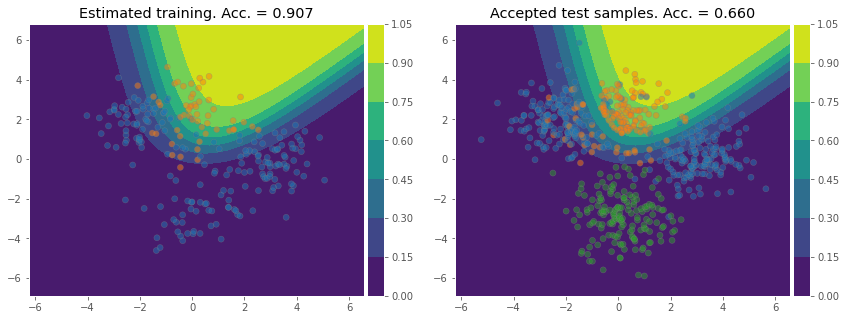

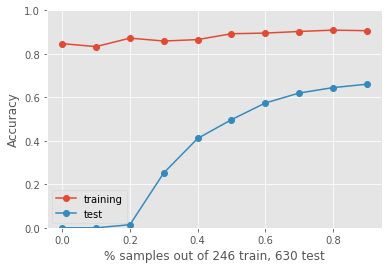

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

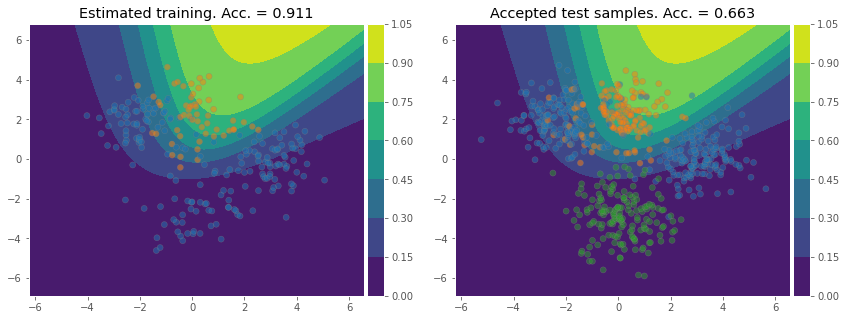

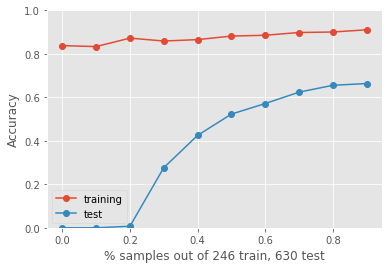

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

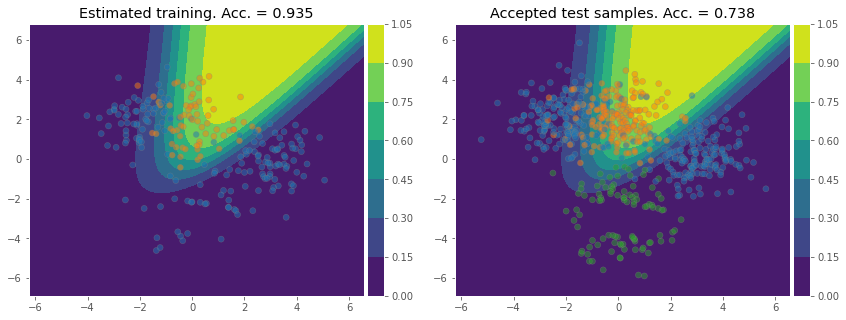

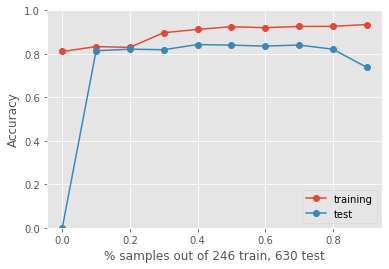

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

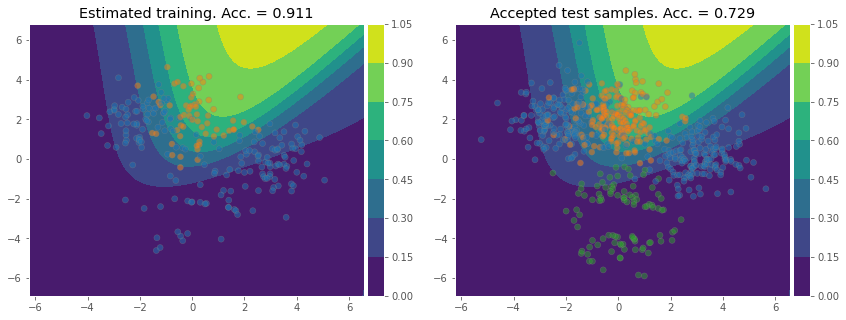

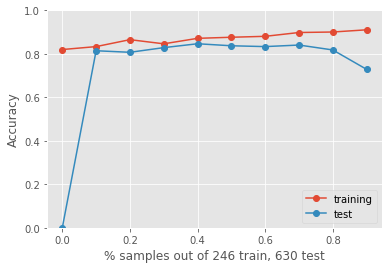

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

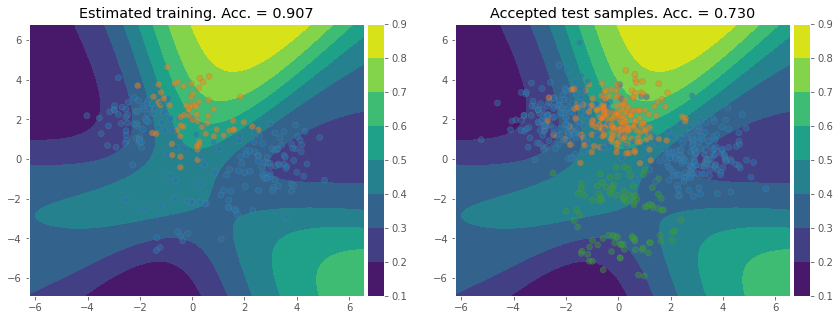

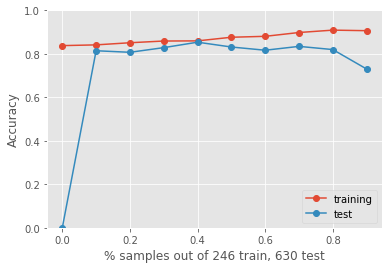

In [12]:
results = {}
for name in ['binary', 'weak', 'bcbinary', 'bcselection', 'bcscaling']:
    r = {}
    r['samples'], r['train'], r['test'], = run_experiment(name=name, iterations=10)
    results[name] = r

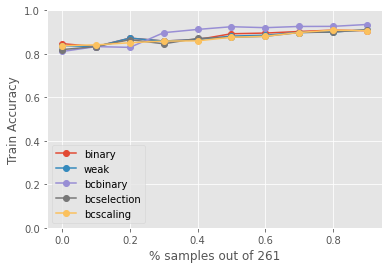

In [13]:
fig, ax = plt.subplots()
for name in ['binary', 'weak',  'bcbinary', 'bcselection', 'bcscaling']:
    ax.plot(results[name]['samples'], results[name]['train'], 'o-', label=name)
ax.set_ylim([0, 1])
ax.legend()
ax.set_ylabel('Train Accuracy')
ax.set_xlabel('% samples out of {}'.format(y_label.shape[0] + y_unlabel.shape[0]))
fig.savefig('{}_{}_evaluation_iteration_train'.format(dataset_name, 'all'))

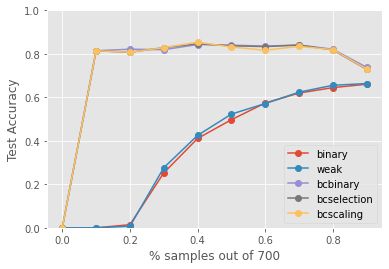

In [14]:
fig, ax = plt.subplots()
for name in ['binary', 'weak',  'bcbinary', 'bcselection', 'bcscaling']:
    ax.plot(results[name]['samples'], results[name]['test'], 'o-', label=name)
ax.set_ylim([0, 1])
ax.legend()
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('% samples out of {}'.format(y_test.shape[0]))
fig.savefig('{}_{}_evaluation_iteration_test'.format(dataset_name, 'all'))